<a href="https://colab.research.google.com/github/nebaraka/kaggle/blob/main/spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install kaleido -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import kaleido

## Preprocessing & EDA

In [4]:
def preprocess_data(df):
    df["CryoSleep"] = df["CryoSleep"].astype(bool)
    df["VIP"] = df["VIP"].astype(bool)

    df["Deck"] = df["Cabin"].apply(lambda x: x[0] if type(x) == str else x)

    df["Side"] = df["Cabin"].apply(lambda x: x[-1] if type(x) == str else x)

    df["CabinNum"] = df["Cabin"].apply(lambda x: float(x.split('/')[1]) if type(x) == str else x)

    df["HomePlanet"].fillna(df["HomePlanet"].mode()[0], inplace=True)
    df["Destination"].fillna(df["Destination"].mode()[0], inplace=True)
    df["Age"].fillna(df["Age"].median(), inplace=True)
    df["RoomService"].fillna(df["RoomService"].median(), inplace=True)
    df["FoodCourt"].fillna(df["FoodCourt"].median(), inplace=True)
    df["ShoppingMall"].fillna(df["ShoppingMall"].median(), inplace=True)
    df["Spa"].fillna(df["Spa"].median(), inplace=True)
    df["VRDeck"].fillna(df["VRDeck"].median(), inplace=True)
    df["Name"].fillna("dummy", inplace=True)
    df["Deck"].fillna(df["Deck"].mode()[0], inplace=True)
    df["Side"].fillna(df["Side"].mode()[0], inplace=True)
    df["CabinNum"].fillna(df["CabinNum"].mode()[0], inplace=True)
    
    df[["Group", "NumInGroup"]] = pd.DataFrame(df.PassengerId.str.split('_').to_list(), columns=["Group", "NumInGroup"])
    df["Group"] = df["Group"].astype(int)
    df["NumInGroup"] = df["NumInGroup"].astype(int)
    
    df["TotExpenses"] = df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"]
    
    df["Spa_FCdif"] = df["Spa"] - df["FoodCourt"]
    
    df["VRDToFC"] = df["VRDeck"]/df["FoodCourt"]
    df["VRDToFC"] = df["VRDToFC"].apply(lambda x: np.nan if x == np.inf else x)
    locmax = df["VRDToFC"].max()
    df["VRDToFC"].fillna(locmax, inplace=True)
    df["VRDToFCDelta"] = df["VRDToFC"] - 1
    
    df["SpaToVRD"] = df["Spa"]/df["VRDeck"]
    df["SpaToVRD"] = df["SpaToVRD"].apply(lambda x: np.nan if x == np.inf else x)
    locmax = df["SpaToVRD"].max()
    df["SpaToVRD"].fillna(locmax, inplace=True)
    
    return df

In [5]:
df = pd.read_csv("train.csv")

df = preprocess_data(df)

### Visualisation

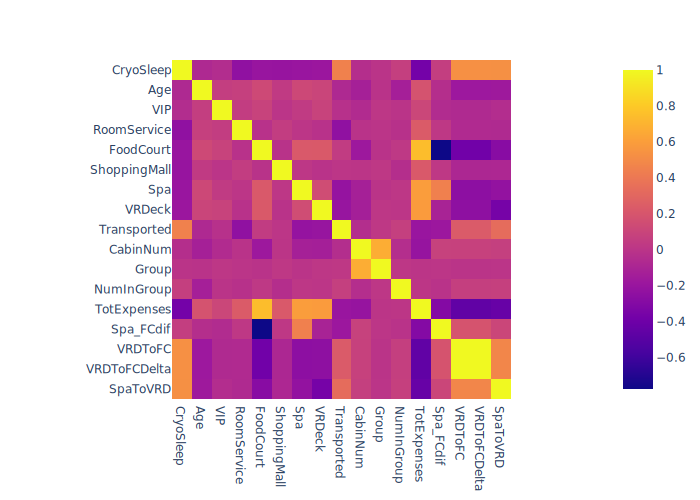

In [6]:
fig = px.imshow(df.corr())
fig.show("svg")

In [7]:
df.corr()["Transported"].apply(abs).sort_values(ascending=False)

Transported     1.000000
CryoSleep       0.451744
SpaToVRD        0.330752
RoomService     0.241124
VRDToFC         0.231407
VRDToFCDelta    0.231407
Spa             0.218545
VRDeck          0.204874
TotExpenses     0.199514
Spa_FCdif       0.183472
Age             0.074233
NumInGroup      0.066390
FoodCourt       0.045583
CabinNum        0.044012
VIP             0.024602
Group           0.021491
ShoppingMall    0.009391
Name: Transported, dtype: float64

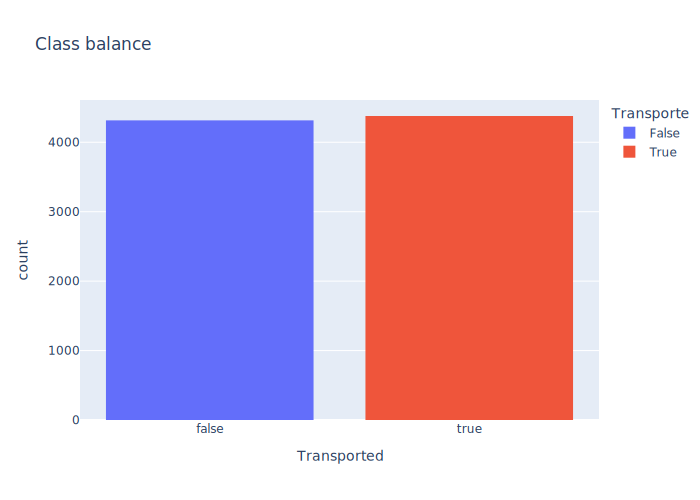

In [8]:
fig = px.histogram(df, x="Transported", color="Transported", 
                   title="Class balance")
fig.show("svg")

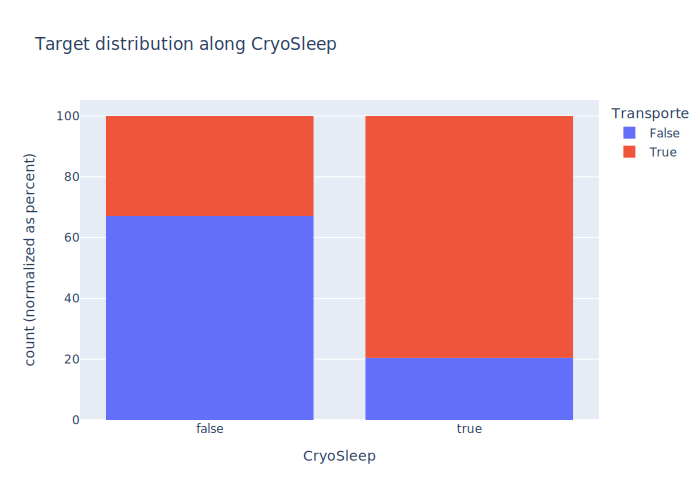

In [9]:
fig = px.histogram(df, x="CryoSleep", color="Transported", barnorm="percent",
                   title="Target distribution along CryoSleep")
fig.show("svg")

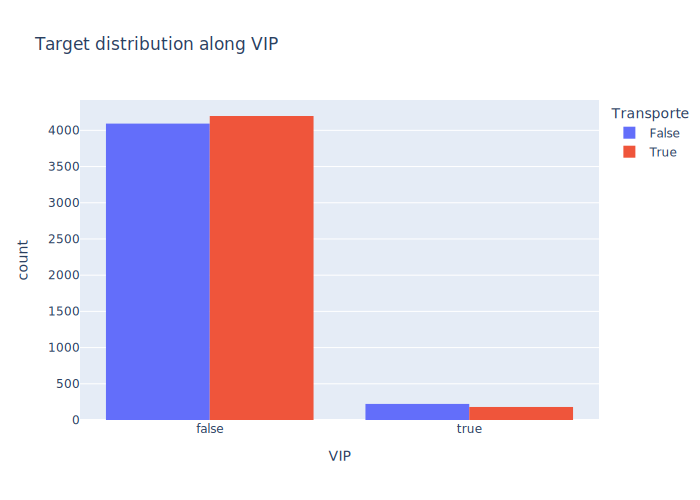

In [10]:
fig = px.histogram(df, x="VIP", color="Transported", barmode="group",
                   title="Target distribution along VIP")
fig.show("svg")

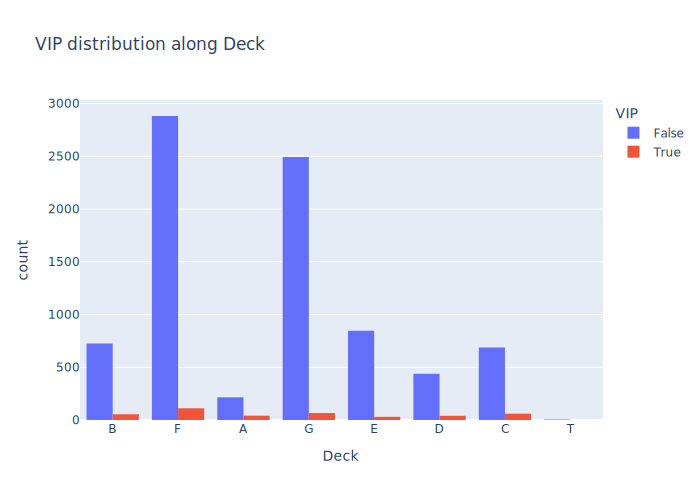

In [11]:
fig = px.histogram(df, x="Deck", color="VIP", barmode="group",
                   title="VIP distribution along Deck")
fig.show("svg")

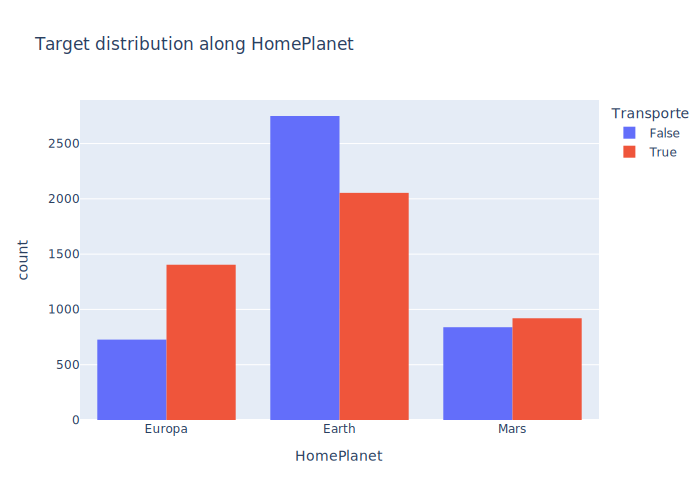

In [12]:
fig = px.histogram(df, x="HomePlanet", color="Transported", barmode="group",
                   title="Target distribution along HomePlanet")
fig.show("svg")

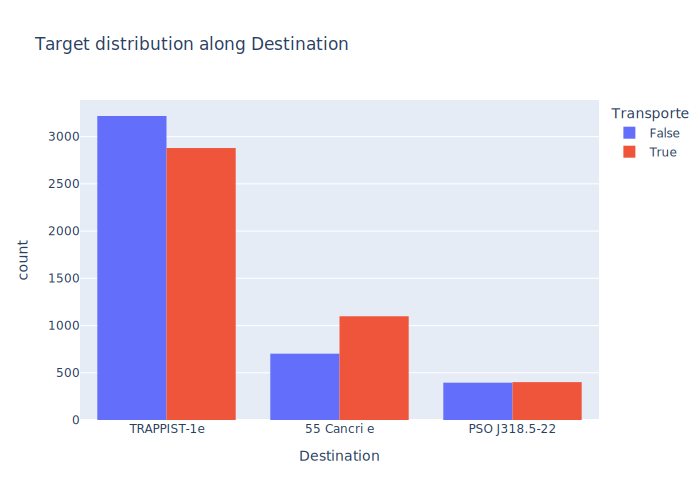

In [13]:
fig = px.histogram(df, x="Destination", color="Transported", barmode="group",
                   title="Target distribution along Destination")
fig.show("svg")

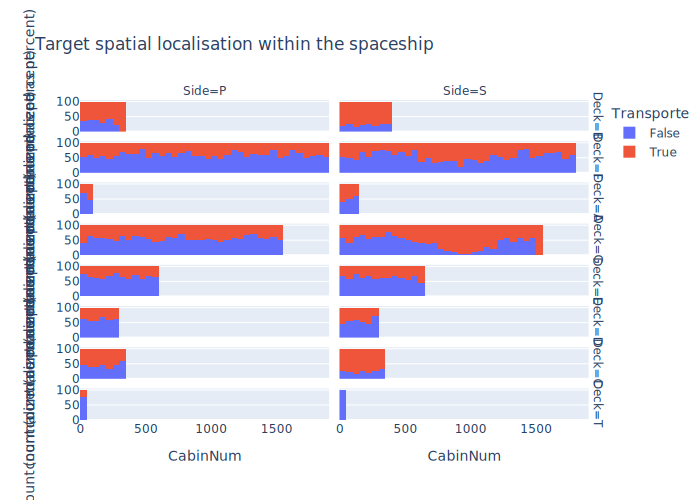

In [14]:
fig = px.histogram(df, x="CabinNum", color="Transported", barnorm="percent", facet_col="Side", facet_row="Deck",
                   title="Target spatial localisation within the spaceship")
fig.show("svg")

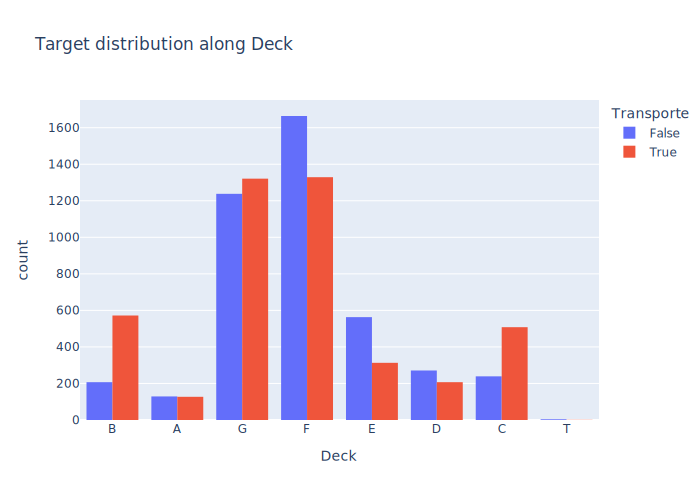

In [15]:
fig = px.histogram(df, x="Deck", color="Transported", barmode="group",
                   title="Target distribution along Deck")
fig.show("svg")

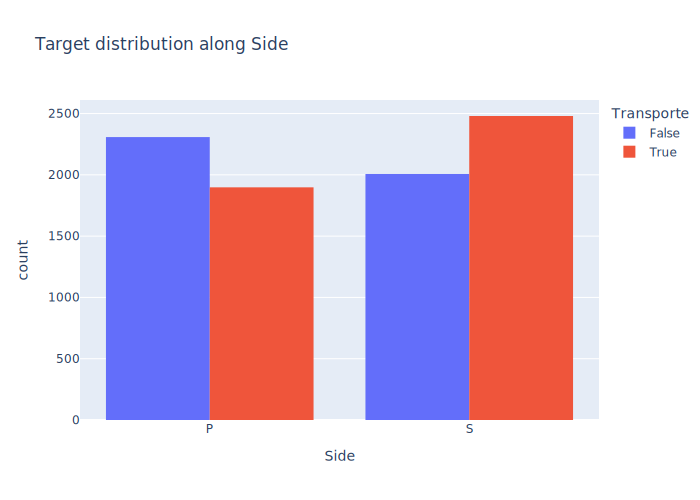

In [16]:
fig = px.histogram(df, x="Side", color="Transported", barmode="group",
                   title="Target distribution along Side")
fig.show("svg")

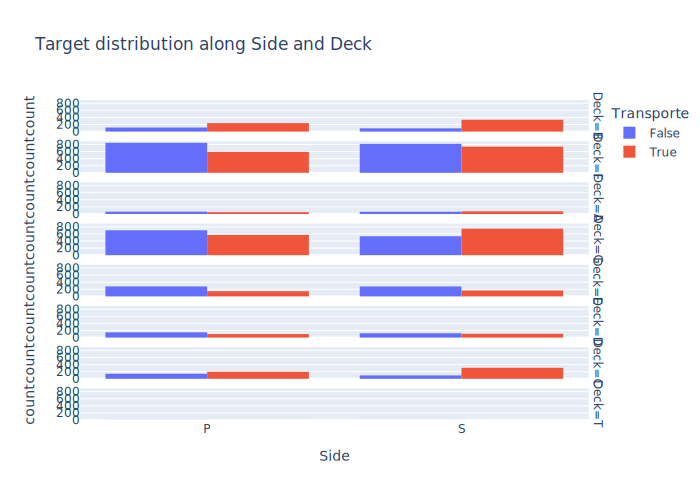

In [17]:
fig = px.histogram(df, x="Side", color="Transported", facet_row="Deck", 
                   barmode="group",
                   title="Target distribution along Side and Deck")
fig.show("svg")

## Modelling

### Imports

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
import xgboost

In [19]:
df["rand1"] = np.random.rand(df.shape[0])
df["rand2"] = np.random.rand(df.shape[0])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Transported", axis=1), 
                                                    df["Transported"], random_state=1453, stratify=df["Transported"])

In [21]:
numerical_columns = ["CabinNum", "Age", "NumInGroup", "RoomService", "VRDeck", "Spa", 
                     'Spa_FCdif', 'SpaToVRD', "rand1", "rand2"]
                    
categorical_columns = ["HomePlanet", "CryoSleep", "Destination", "Deck", "Side", "ShoppingMall", "Group"]

In [22]:
# Excluded features
#["Group", "ShoppingMall", "FoodCourt", "ShoppingMall", "TotExpenses", 
# 'VRDToFC', 'VRD_FCdif', 'VRDToFCDelta']
#["VIP", "Name", "PassengerId"]]

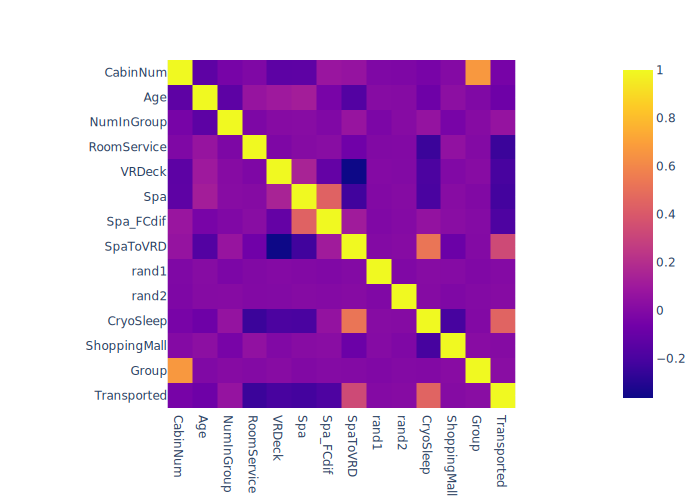

In [23]:
fig = px.imshow(df[numerical_columns + categorical_columns + ["Transported"]].corr())
fig.show("svg")

In [24]:
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
numerical_transformer_mm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohencoder", OneHotEncoder(handle_unknown="ignore"))
])
data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_columns),
    ("categorical", categorical_transformer, categorical_columns)
])
preprocessor = Pipeline(steps=[
    ("data_transformer", data_transformer)
])
data_transformer_mm = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer_mm, numerical_columns),
    ("categorical", categorical_transformer, categorical_columns)
])
preprocessor_mm = Pipeline(steps=[
    ("data_transformer", data_transformer_mm)
])

### Baseline

In [25]:
y_pred = X_test["CryoSleep"]

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.65      0.84      0.74      1079
        True       0.78      0.56      0.65      1095

    accuracy                           0.70      2174
   macro avg       0.72      0.70      0.69      2174
weighted avg       0.72      0.70      0.69      2174

0.6996320147194113


#### Logistic Regression

In [26]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(solver="saga", max_iter=1000))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.79      0.77      0.78      1079
        True       0.78      0.80      0.79      1095

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174

0.7851885924563018


In [27]:
fnames = np.concatenate([np.array(numerical_columns), model["preprocessor"]["data_transformer"].transformers_[1][1]["ohencoder"].get_feature_names_out()])
coefs = model["estimator"].coef_
coefs = pd.DataFrame({"name": fnames, "coef": coefs.reshape(-1)})

coefs.sort_values("coef", inplace=True)

In [28]:
fig = px.histogram(coefs[coefs.apply(lambda x: x["name"] in numerical_columns, axis=1)], x="name", y="coef")
fig.add_vline(x="rand1", line_color="red")
fig.add_vline(x="rand2", line_color="red")
fig.show()

#### GridSearch LR

In [29]:
lr_params = {
    "classifier__C": np.linspace(0, 5, 10),
    "classifier__penalty": ["l1", "l2"],
    "classifier__class_weight": ["balanced", None],
    
    "preprocessor__data_transformer__numerical__imputer__strategy": ["median", "mean"]
}

In [30]:
LR_pipeline_ = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver="saga", max_iter=500))
])
lr_search = GridSearchCV(LR_pipeline_, lr_params, n_jobs=-1, cv=3, verbose=1)


In [31]:
%%time
lr_search.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


12 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1589, in fit
    fold_coefs_ = Parallel(
  File "/usr/local/lib/python3.8/dist-pa

CPU times: user 14.9 s, sys: 1.67 s, total: 16.5 s
Wall time: 22min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['CabinNum',
                                                                                           'Age',
                                       

In [32]:
print(lr_search.best_params_)

{'classifier__C': 0.5555555555555556, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'preprocessor__data_transformer__numerical__imputer__strategy': 'median'}


#### Naive Bayes

In [33]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", BernoulliNB(alpha=25))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.73      0.77      0.75      1079
        True       0.76      0.72      0.74      1095

    accuracy                           0.74      2174
   macro avg       0.74      0.74      0.74      2174
weighted avg       0.74      0.74      0.74      2174

0.7428702851885924


#### Random forest

In [34]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", RandomForestClassifier(random_state=1453))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.75      0.84      0.79      1079
        True       0.82      0.72      0.77      1095

    accuracy                           0.78      2174
   macro avg       0.78      0.78      0.78      2174
weighted avg       0.78      0.78      0.78      2174

0.7778288868445262


#### GridSearch RF

In [ ]:
rf_params = {
    "classifier__n_estimators": [30, 100, 300], # 
    "classifier__criterion": ["entropy", "gini"],
    "classifier__max_depth": [20],
    "classifier__min_samples_split": [2, 4, 8],
    "classifier__min_samples_leaf": [2],
    "classifier__max_features": ["sqrt"],
#     "classifier__random_state": [1453],
}

In [ ]:
rf_pipeline_ = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier())
])
rf_search = GridSearchCV(rf_pipeline_, rf_params, n_jobs=-1, cv=10, verbose=1)

In [ ]:
%%time
rf_search.fit(X_train, y_train)

In [ ]:
print(rf_search.best_params_)

#### RF with the best params

In [35]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", RandomForestClassifier(criterion="gini", max_depth=300, 
                                         max_features="sqrt", min_samples_leaf=2, 
                                         min_samples_split=8, n_estimators=30, 
                                         random_state=1453))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.72      0.81      0.76      1079
        True       0.78      0.69      0.74      1095

    accuracy                           0.75      2174
   macro avg       0.75      0.75      0.75      2174
weighted avg       0.75      0.75      0.75      2174

0.749770009199632


#### XGBoost

In [36]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", xgboost.XGBClassifier())
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.76      0.78      1079
        True       0.78      0.83      0.80      1095

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174

0.7934682612695492


#### XGB GridSearch

In [ ]:
XGB_grid_params = {
    "classifier__eval_metric": ["logloss"], # , "aucpr", "auc"
    "classifier__subsample": [0.75], # 0-1
    "classifier__colsample_bytree": [0.75], # 0-1
    "classifier__max_delta_step": [1.5], #1-10
    "classifier__objective": ["binary:logistic"], # , "binary:logitraw"
#     "classifier__num_class": [2],
    "classifier__n_estimators": [30], # list(range(30, 100, 10)) + list(range(210, 260, 10))
    "classifier__max_depth": [10], # 5, 8, 10
    "classifier__max_leaves": [None], # 
    "classifier__gamma": [5.71], # np.linspace(0, 10, 8),
    "classifier__grow_policy": ["lossguide"], # depthwise
    "classifier__booster": ["gbtree"],
    "classifier__tree_method": ["gpu_hist"],
#     "classifier__gpu_id": [0],
#     "classifier__random_state": [1453], 
    "classifier__learning_rate": [0.25], # 0.25, 0.75
    "classifier__lambda": np.linspace(0, 5, 8), #np.logspace(-10, 10, 3, base=1.1),
    "classifier__alpha": np.linspace(0, 5, 8), #np.logspace(-10, 10, 3, base=1.1),
}

In [ ]:
XGB_pipeline_ = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgboost.XGBRFClassifier()) #RF
])
XGB_search = GridSearchCV(XGB_pipeline_, XGB_grid_params, n_jobs=-1, cv=10, verbose=1)

In [ ]:
%%time
XGB_search.fit(X_train, y_train.values.reshape((-1, 1)))

In [ ]:
print(XGB_search.best_params_)

#### Xgboost with the best params

In [38]:
xgb_top_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", xgboost.XGBClassifier(alpha=0, booster="gbtree", 
                                        colsample_bytree=0.75, 
                                        eval_metric="logloss", 
                                        gamma=2.86,
                                        grow_policy="lossguide",
                                        reg_lambda=3.57, learning_rate=0.25,
                                        max_delta_step=0.75, max_depth=10,
                                        max_leaves=10, n_estimators=230,
                                        objective="binary:logistic", random_state=1453,
                                        subsample=0.75, tree_method="hist"))
])
xgb_top_model.fit(X_train, y_train)
y_pred = xgb_top_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.79      0.81      0.80      1079
        True       0.80      0.79      0.80      1095

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174

0.797608095676173


In [39]:
fnames = np.concatenate([np.array(numerical_columns), model["preprocessor"]["data_transformer"].transformers_[1][1]["ohencoder"].get_feature_names_out()])
coef = pd.DataFrame({"coef": model["estimator"].feature_importances_, "name": fnames}).sort_values("coef")

In [41]:
px.histogram(coef, x="name", y="coef")

## Stacking

In [47]:
estimators=[
    ("xgb", xgboost.XGBClassifier(alpha=0, booster="gbtree", 
                                        colsample_bytree=0.75, 
                                        eval_metric="logloss", 
                                        gamma=2.86,
                                        grow_policy="lossguide",
                                        reg_lambda=3.57, learning_rate=0.25,
                                        max_delta_step=0.75, max_depth=10,
                                        max_leaves=10, n_estimators=230,
                                        objective="binary:logistic", random_state=1453,
                                        subsample=0.75, tree_method="hist")),
    ("rf", RandomForestClassifier(criterion='gini',
                                     max_depth=20,
                                     max_features='sqrt',
                                     min_samples_leaf=2,
                                     min_samples_split=8,
                                     n_estimators=300)),
    ("lr", LogisticRegression(C=4, class_weight="balanced", penalty="l2", solver="saga")),
    ("nb", BernoulliNB(alpha=25)),
]

### Logistic Regression

In [43]:
from sklearn.ensemble import StackingClassifier

In [48]:
stacking_clf = StackingClassifier(estimators=estimators, 
    final_estimator=LogisticRegression(C=0.41, penalty="l2", solver="saga", n_jobs=-1, verbose=True, random_state=1453),
    n_jobs=-1,
    verbose=True,
)
stacking_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", stacking_clf)
])

In [49]:
stacking_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 16 epochs took 0 seconds


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['CabinNum',
                                                                    'Age',
                                                                    'NumInGroup',
                                                                    'RoomService',
                                                                    'VRDeck',
                      

In [50]:
y_pred = stacking_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.79      0.80      1079
        True       0.79      0.81      0.80      1095

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174

0.7999080036798528


In [51]:
stacking_clf = StackingClassifier(estimators=estimators, 
    final_estimator=LogisticRegression(C=0.41, penalty="l2", solver="saga", n_jobs=-1, verbose=True, random_state=1453),
    n_jobs=-1,
    verbose=True,
)
stacking_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", stacking_clf)
])

In [52]:
scores = cross_val_score(stacking_pipeline, df.drop(["Transported"], axis=1), df["Transported"], cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(

In [53]:
scores.mean()

0.7863833228228596

### SVM

In [54]:
stacking_clf_svm = StackingClassifier(estimators=estimators, 
    final_estimator=SVC(C=9.18, kernel="rbf", shrinking=False, verbose=True, random_state=10),
    n_jobs=-1,
    verbose=True,
)
stacking_pipeline_svm = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", stacking_clf_svm)
])

In [55]:
stacking_pipeline_svm.fit(X_train, y_train)
y_pred = stacking_pipeline_svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[LibSVM]              precision    recall  f1-score   support

       False       0.80      0.78      0.79      1079
        True       0.79      0.81      0.80      1095

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174

0.797608095676173


#### GridSearch

In [ ]:
stacking_params = {
    "estimator__final_estimator__C": np.linspace(0, 10, 50),
    "estimator__final_estimator__kernel": ["linear", "poly", "rbf", "sigmoid"],
#     "estimator__final_estimator__solver": ["saga"],
#     "estimator__final_estimator__random_state": np.logspace(1, 10, 20),
}
stacking_search = GridSearchCV(stacking_pipeline_svm, stacking_params, n_jobs=-1, cv=3, verbose=1)
stacking_search.fit(X_train, y_train)

In [ ]:
stacking_search.best_params_

In [ ]:
stacking_pipeline.fit(df.drop(["Transported"], axis=1), df["Transported"]) #, "rand1", "rand2"

df_test = pd.read_csv("test.csv")

df_test = preprocess_data(df_test)

y_pred = stacking_pipeline.predict(df_test)

pd.DataFrame({"PassengerId": df_test["PassengerId"], "Transported": y_pred}).to_csv("submission.csv", index=False)